In [1]:
import tensorflow as tf
import numpy as np
from model_mn import MATCH_NET
import time
import os, re, glob
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import skimage
import skimage.io

import warnings
warnings.simplefilter('ignore')

from ops import *
from utils import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## (0) Specify paths and hyperparameters

In [2]:
image_path = '/data/put_data/cclin/datasets/omniglot/python/images_all'
result_path = '/home/cclin/few_shot_learning/match_net/results'
dir_name = 'N5k1' # specify N and k for the N-way k-shot task

y_dim = int(re.search('N([0-9]+)k[0-9]+', dir_name).group(1)) # N: possible classes
n_samples_per_class = int(re.search('N[0-9]+k([0-9]+)', dir_name).group(1)) # k: samples of each class
n_samples = y_dim * n_samples_per_class # total number of labeled samples

drawing_per_char = 20 # number of drawing per character, 20 for omniglot
x_dim = 28  # size of one side of square image
n_iteration = 100000
Batch_Size = 32
learning_rate = 4e-5

## Not used
tie = False # tie the weights of the query network to the labeled network
x_i_learn = True # toggle learning for the query network

## (1) Data Preparation and Visualization

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

def plot(samples, n_row, n_col):
    fig = plt.figure(figsize=(n_col*2, n_row*2))
    gs = gridspec.GridSpec(n_row, n_col)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(x_dim, x_dim), cmap='gray')
    return fig

In [4]:
arr = np.arange(1623)
np.random.shuffle(arr)

In [5]:
## make filepath-label array.
## E.g., [['/data/put_data/cclin/datasets/omniglot/python/images_all/Alphabet_of_the_Magi/character01', 0],
##        ['/data/put_data/cclin/datasets/omniglot/python/images_all/Alphabet_of_the_Magi/character02', 1],
##        ...,
##        ['/data/put_data/cclin/datasets/omniglot/python/images_all/ULOG/character26', 1622]]
## shape: (1623, 2)
label_idx = 0
list_all = []
alphabet_list = np.sort(os.listdir(image_path))
for alphabet in alphabet_list:
    alphabet_path = os.path.join(image_path, alphabet)
    char_list = np.sort(os.listdir(alphabet_path))
    for char in char_list:
        char_path = os.path.join(image_path, alphabet, char)
        list_all.append([os.path.join(image_path, alphabet, char), label_idx])
        label_idx = label_idx + 1
list_all = np.asarray(list_all)
print(list_all.shape)
print(len(np.unique(list_all[:,1])))

(1623, 2)
1623


In [6]:
## randomly choose 1200 characters for training
## note: 'arr' is a randomly shuffled list containing {0, 1, ..., 1622}
keys_train = arr[:1200]
print('First 10 training labels: %s' % keys_train[:10])
for i in range(10):
    print('    %s' % list_all[keys_train[i]][0])
keys_test = arr[1200:]
print('First 10 testing labels: %s' % keys_test[:10])
for i in range(10):
    print('    %s' % list_all[keys_test[i]][0])

First 10 training labels: [ 585 1567  524  178 1164  816 1439   41  732 1488]
    /data/put_data/cclin/datasets/omniglot/python/images_all/Grantha/character10
    /data/put_data/cclin/datasets/omniglot/python/images_all/Tifinagh/character26
    /data/put_data/cclin/datasets/omniglot/python/images_all/Ge_ez/character20
    /data/put_data/cclin/datasets/omniglot/python/images_all/Atemayar_Qelisayer/character03
    /data/put_data/cclin/datasets/omniglot/python/images_all/Mkhedruli_(Georgian)/character32
    /data/put_data/cclin/datasets/omniglot/python/images_all/Japanese_(hiragana)/character43
    /data/put_data/cclin/datasets/omniglot/python/images_all/Syriac_(Serto)/character05
    /data/put_data/cclin/datasets/omniglot/python/images_all/Anglo-Saxon_Futhorc/character02
    /data/put_data/cclin/datasets/omniglot/python/images_all/Gurmukhi/character42
    /data/put_data/cclin/datasets/omniglot/python/images_all/Tengwar/character14
First 10 testing labels: [ 738 1362 1295 1363  302  491 1

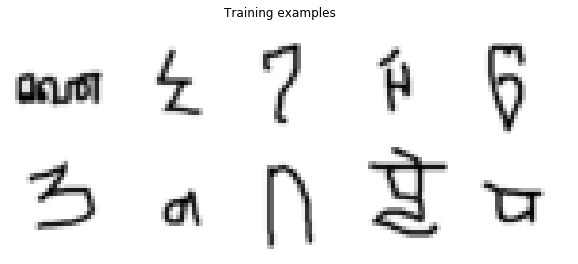

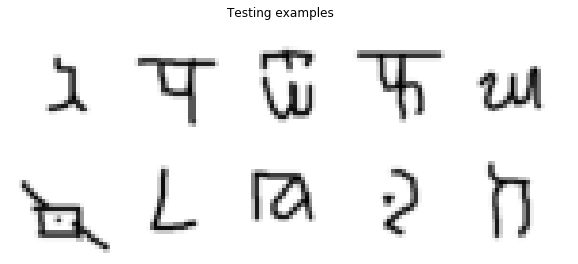

In [7]:
## show some examples (resize to 28x28)
images = []
for i in range(10):
    image_list = np.sort(glob.glob(os.path.join(list_all[keys_train[i]][0], '*.png')))
    ### note: both get_image() and transform() are from utils.py
    images.append(transform(get_image(image_list[0]), 105, 105, resize_height=x_dim, resize_width=x_dim, crop=False))
fig = plot(images, 2, 5)
fig.suptitle('Training examples')
fig.show()

images = []
for i in range(10):
    image_list = np.sort(glob.glob(os.path.join(list_all[keys_test[i]][0], '*.png')))
    ### note: both get_image() and transform() are from utils.py
    images.append(transform(get_image(image_list[0]), 105, 105, resize_height=x_dim, resize_width=x_dim, crop=False))
fig = plot(images, 2, 5)
fig.suptitle('Testing examples')
fig.show()

In [ ]:
## use data format 2, with two lists (training and testing)
list_train = list_all[keys_train]
list_test = list_all[keys_test]
print(list_train)
print(list_train[:,1])
print(list_train.shape[0])

[['/data/put_data/cclin/datasets/omniglot/python/images_all/Grantha/character10'
  '585']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Tifinagh/character26'
  '1567']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Ge_ez/character20'
  '524']
 ...
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Tifinagh/character52'
  '1593']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Burmese_(Myanmar)/character05'
  '394']
 ['/data/put_data/cclin/datasets/omniglot/python/images_all/Mkhedruli_(Georgian)/character17'
  '1149']]
['585' '1567' '524' ... '1593' '394' '1149']
1200


## (2) Training

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    net = MATCH_NET(sess,
                    result_path=result_path,
                    model_name=dir_name,
                    y_dim=y_dim,
                    n_samples_per_class=n_samples_per_class,
                    drawing_per_char=drawing_per_char)
    net.build_model()
    results = net.train(list_train=list_train,
                        list_test=list_test,
                        n_iteration=n_iteration,
                        bsize=Batch_Size,
                        learning_rate_start=learning_rate)

ite: 100 | train_loss: 1.1492 | train_acc: 0.5938 | test_loss: 1.2790 | test_acc: 0.4375
ite: 200 | train_loss: 1.0061 | train_acc: 0.6562 | test_loss: 0.9930 | test_acc: 0.6250
ite: 300 | train_loss: 0.9479 | train_acc: 0.6562 | test_loss: 0.9199 | test_acc: 0.6875
ite: 400 | train_loss: 0.6294 | train_acc: 0.8750 | test_loss: 0.6488 | test_acc: 0.8438
ite: 500 | train_loss: 0.7587 | train_acc: 0.6562 | test_loss: 0.6564 | test_acc: 0.7812
ite: 600 | train_loss: 0.8172 | train_acc: 0.7188 | test_loss: 0.7479 | test_acc: 0.6875
ite: 700 | train_loss: 0.9675 | train_acc: 0.5938 | test_loss: 0.9461 | test_acc: 0.5938
ite: 800 | train_loss: 0.6909 | train_acc: 0.7812 | test_loss: 0.7305 | test_acc: 0.7500
ite: 900 | train_loss: 0.7611 | train_acc: 0.7812 | test_loss: 0.8210 | test_acc: 0.6875
ite: 1000 | train_loss: 0.7134 | train_acc: 0.6875 | test_loss: 0.9800 | test_acc: 0.5938
ite: 1100 | train_loss: 0.6469 | train_acc: 0.8125 | test_loss: 0.8340 | test_acc: 0.6250
ite: 1200 | train_l

## (3) Inference

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    net = MATCH_NET(sess,
                    result_path=result_path,
                    model_name=dir_name,
                    y_dim=y_dim,
                    n_samples_per_class=n_samples_per_class,
                    drawing_per_char=drawing_per_char)
    net.build_model()
    results = net.inference(list_test=list_test,
                            n_iteration=1000,
                            gen_from=os.path.join(result_path, dir_name, 'models'),
#                             gen_from_ckpt=dir_name+'.model-210',
#                             out_path=os.path.join('/data/put_data/cclin/ntu/dlcv2018/hw4/results', dir_name),
                            bsize=Batch_Size*10)